<a href="https://colab.research.google.com/github/mykon23/DL-2020Project/blob/effect_of_reg/Equus6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get the Equus Dataset

In [39]:
! wget -O Equus.tar.gz https://github.com/mykon23/DL-2020Project/blob/master/Equus.tar.gz?raw=true

--2020-04-23 15:43:57--  https://github.com/mykon23/DL-2020Project/blob/master/Equus.tar.gz?raw=true
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mykon23/DL-2020Project/raw/master/Equus.tar.gz [following]
--2020-04-23 15:43:58--  https://github.com/mykon23/DL-2020Project/raw/master/Equus.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mykon23/DL-2020Project/master/Equus.tar.gz [following]
--2020-04-23 15:43:58--  https://raw.githubusercontent.com/mykon23/DL-2020Project/master/Equus.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting resp

In [0]:
! rm -rf Equus
! tar -zxf Equus.tar.gz

In [0]:
! rm *.tar.gz
! rm -rf train/
! rm -rf validation/
! rm -rf test/

Create the Training Set, Validation Set, and Test Set

In [0]:
import os

##Creates the folder structure of the data staging locations
def set_dataset_loc(loc, sub_dirs):
  if not os.path.exists(loc):
    os.mkdir(loc)
    for s in sub_dirs:
      os.mkdir(os.path.join(loc, s))


dataset_dir = os.path.join('.', 'Equus')
lst_members = os.listdir(dataset_dir)

set_dataset_loc(os.path.join('.', 'train'), lst_members)
set_dataset_loc(os.path.join('.', 'validation'), lst_members)
set_dataset_loc(os.path.join('.', 'test'), lst_members)


In [43]:
##Display distribution of data

for d in os.listdir(dataset_dir):
  print(f'{d}: {len(os.listdir(os.path.join(dataset_dir, d)))}')

Horse: 314
Zebra: 339
Donkey: 391


In [44]:
!ls -lh

total 86M
-rw-r--r-- 1 root root 7.2M Apr 23 15:13 4ConvMaxPool3DenseBaseline.h5
-rw-r--r-- 1 root root 7.2M Apr 23 15:22 4ConvMaxPool3DenseBatch03.h5
-rw-r--r-- 1 root root 7.2M Apr 23 15:21 4ConvMaxPool3DenseBatch04.h5
-rw-r--r-- 1 root root 7.2M Apr 23 15:19 4ConvMaxPool3DenseDrop02.h5
-rw-r--r-- 1 root root 7.2M Apr 23 15:19 4ConvMaxPool3DenseDrop035.h5
-rw-r--r-- 1 root root 7.2M Apr 23 15:20 4ConvMaxPool3DenseDrop05.h5
-rw-r--r-- 1 root root 7.2M Apr 23 15:30 4ConvMaxPool3DenseL10005.h5
-rw-r--r-- 1 root root 7.2M Apr 23 15:32 4ConvMaxPool3DenseL1001.h5
-rw-r--r-- 1 root root 7.2M Apr 23 15:15 4ConvMaxPool3DenseL101.h5
-rw-r--r-- 1 root root 7.2M Apr 23 15:18 4ConvMaxPool3DenseL20005.h5
-rw-r--r-- 1 root root 7.2M Apr 23 15:16 4ConvMaxPool3DenseL2001.h5
-rw-r--r-- 1 root root 7.2M Apr 23 15:17 4ConvMaxPool3DenseL201.h5
drwxr-xr-x 5 root root 4.0K Mar 16 03:00 Equus
drwxr-xr-x 1 root root 4.0K Apr  3 16:24 sample_data
drwxr-xr-x 5 root root 4.0K Apr 23 15:44 test
drwxr-xr-x 5 root

In [0]:
import shutil

##Populate the staging locations for the data
def stage_data_loc(stage_loc, data_loc, dict_ind):

  ##Create a dictionary containing the images
  dict_images = { k : os.listdir(os.path.join(data_loc, k)) for k in lst_members }

  for k in dict_images.keys():
    for i in range(dict_ind[k][0], dict_ind[k][1]):
      src = os.path.join(os.path.join(data_loc, k), dict_images[k][i])
      dst = os.path.join(os.path.join(stage_loc, k), dict_images[k][i])
      shutil.copyfile(src, dst)

##Keep indices for the data splits
dict_train = {'Donkey': [0, 240], 'Horse': [0, 185], 'Zebra':[0, 185]}
dict_val = {'Donkey': [240, 315], 'Horse': [185, 250], 'Zebra':[185, 249]}
dict_test = {'Donkey': [315, 391], 'Horse': [250, 314],'Zebra': [249, 339]}

stage_data_loc(os.path.join('.', 'train'), dataset_dir, dict_train)
stage_data_loc(os.path.join('.', 'validation'), dataset_dir, dict_val)
stage_data_loc(os.path.join('.', 'test'), dataset_dir, dict_test)


In [46]:
##Count the number of files within each directory
! ls -lh train/*/* | wc -l
! ls -lh validation/*/* | wc -l
! ls -lh test/*/* | wc -l

610
204
230


Define Train and Test Operations

In [0]:
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

def train_model(model, train, val, model_path):
  ##Set the callbacks
  callback_list = [
  tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    ),
  tf.keras.callbacks.ModelCheckpoint(
      filepath=model_path,
      monitor='val_loss',
      save_best_only=True,
    )
  ]

  ##Train the model
  history = model.fit(
      train['gen'],
      steps_per_epoch=train['steps'],
      epochs=50,
      callbacks = callback_list,
      validation_data=val['gen'],
      validation_steps=val['steps'])
  
  return history

def disp_plot(history, title):
  plt.figure()
  plt.plot(history.history['accuracy'], 'bo', label='Training Acc')
  plt.plot(history.history['val_accuracy'], 'b', label='Validation Acc')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.title(title)
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(history.history['loss'], 'bo', label='Training Loss')
  plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.title(title)
  plt.legend()
  plt.show()

def test_model(model, test):
  ##Observe the results of the model against the test data
  test_loss, test_acc = model.evaluate(
    test['gen'],
    steps=test['steps']
  )
  
  return {'accuracy': test_acc, 'loss': test_loss }


Establish Baseline Data Generators

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join('.', 'train')
val_dir = os.path.join('.', 'validation')
test_dir = os.path.join('.', 'test')

train_batches = 61
val_batches = 17
test_batches = 23

##Create Development Set Generators
##Note that 61 * 10 = 610 training samples
train_generator = ImageDataGenerator(rescale=1./255,
                                     ).flow_from_directory(train_dir, target_size=(256, 256), batch_size=10, class_mode='categorical')
##Note that 17 * 12 = 240 validation samples
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(256, 256), batch_size=12, class_mode='categorical')

##Create Test Generator
##Note that 23 * 10 = 230 Test samples
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(256,256), batch_size=10, class_mode='categorical')

Found 610 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 230 images belonging to 3 classes.


Observe Benchmark with no Regularization

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 28, 28, 32)      

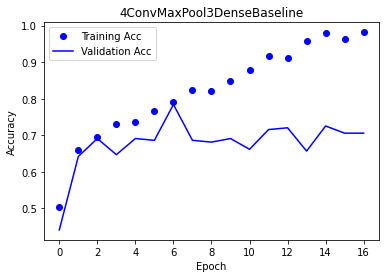

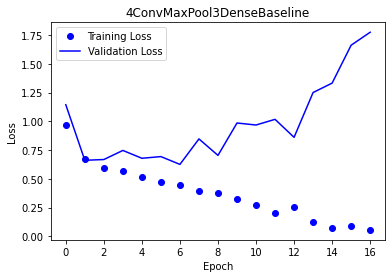

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseBaseline.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [50]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 1s 22ms/step - loss: 0.6027 - accuracy: 0.7609
Test: {'accuracy': 0.760869562625885, 'loss': 0.6026506423950195}
17/17 [==============================] - 1s 30ms/step - loss: 0.6388 - accuracy: 0.7353
Val: {'accuracy': 0.7352941036224365, 'loss': 0.638841986656189}
61/61 [==============================] - 2s 26ms/step - loss: 0.3656 - accuracy: 0.8770
Train: {'accuracy': 0.8770492076873779, 'loss': 0.3655684292316437}


Observe L1 Regularization

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 28, 28, 32)      

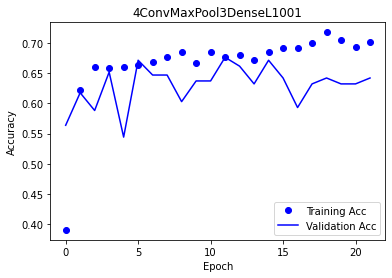

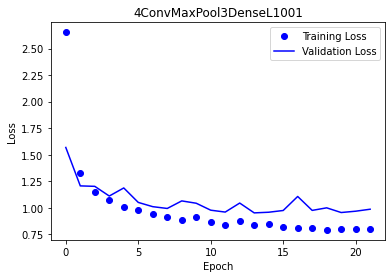

In [51]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

reg = regularizers.L1L2(l1=0.001)

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), kernel_regularizer=reg, activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 12, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 3, kernel_regularizer=reg, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseL1001.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [52]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 1s 24ms/step - loss: 0.9004 - accuracy: 0.6870
Test: {'accuracy': 0.686956524848938, 'loss': 0.9004462957382202}
17/17 [==============================] - 1s 30ms/step - loss: 0.9851 - accuracy: 0.6275
Val: {'accuracy': 0.6274510025978088, 'loss': 0.9850614070892334}
61/61 [==============================] - 2s 25ms/step - loss: 0.8223 - accuracy: 0.6885
Train: {'accuracy': 0.688524603843689, 'loss': 0.822286069393158}


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 28, 28, 32)      

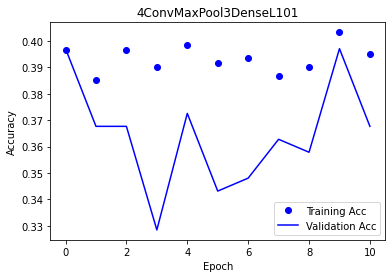

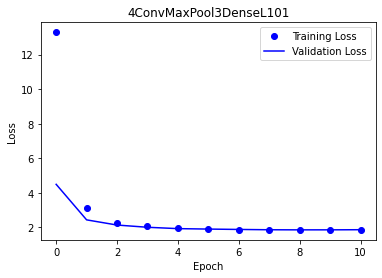

In [53]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

reg = regularizers.L1L2(l1=0.01)

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), kernel_regularizer=reg, activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 12, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 3, kernel_regularizer=reg, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseL101.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [54]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 1s 25ms/step - loss: 1.8606 - accuracy: 0.3348
Test: {'accuracy': 0.33478260040283203, 'loss': 1.860573649406433}
17/17 [==============================] - 1s 30ms/step - loss: 1.8543 - accuracy: 0.3676
Val: {'accuracy': 0.36764705181121826, 'loss': 1.8542674779891968}
61/61 [==============================] - 2s 25ms/step - loss: 1.8503 - accuracy: 0.3902
Train: {'accuracy': 0.39016392827033997, 'loss': 1.8502525091171265}


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 28, 28, 32)      

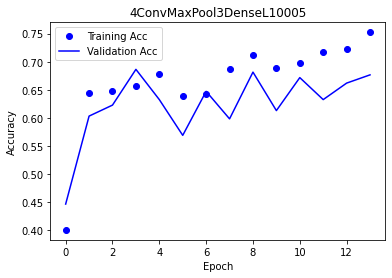

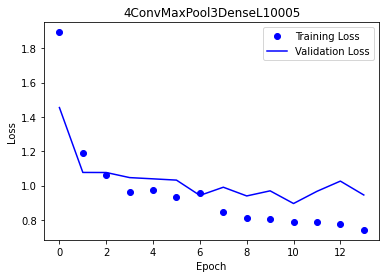

In [55]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

reg = regularizers.L1L2(l1=0.0005)

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), kernel_regularizer=reg, activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 12, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 3, kernel_regularizer=reg, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseL10005.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [56]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 1s 25ms/step - loss: 1.0184 - accuracy: 0.6348
Test: {'accuracy': 0.634782612323761, 'loss': 1.0183871984481812}
17/17 [==============================] - 0s 28ms/step - loss: 1.0177 - accuracy: 0.6029
Val: {'accuracy': 0.6029411554336548, 'loss': 1.0177263021469116}
61/61 [==============================] - 2s 25ms/step - loss: 0.7646 - accuracy: 0.7000
Train: {'accuracy': 0.699999988079071, 'loss': 0.764616847038269}


Observe L2 Regularization

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 28, 28, 32)      

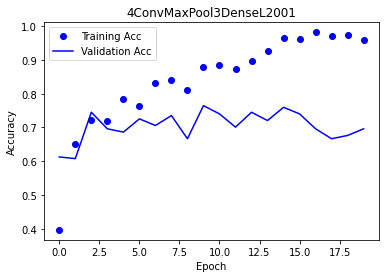

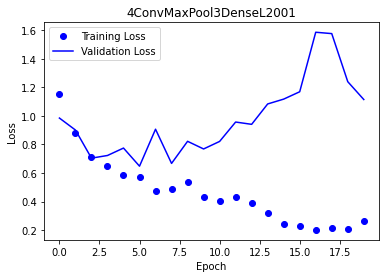

In [57]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

reg = regularizers.L1L2(l2=0.001)

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), kernel_regularizer=reg, activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 12, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 3, kernel_regularizer=reg, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseL2001.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [58]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 1s 23ms/step - loss: 0.6501 - accuracy: 0.7652
Test: {'accuracy': 0.7652173638343811, 'loss': 0.6501156687736511}
17/17 [==============================] - 0s 29ms/step - loss: 0.7517 - accuracy: 0.7353
Val: {'accuracy': 0.7352941036224365, 'loss': 0.7516997456550598}
61/61 [==============================] - 2s 26ms/step - loss: 0.4891 - accuracy: 0.8311
Train: {'accuracy': 0.8311475515365601, 'loss': 0.4891136586666107}


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 28, 28, 32)      

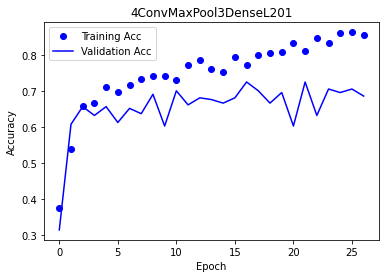

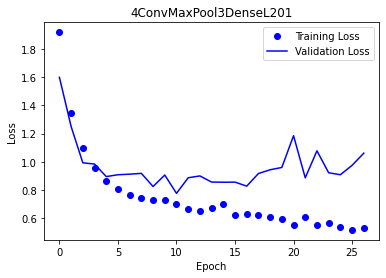

In [59]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

reg = regularizers.L1L2(l2=0.01)

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), kernel_regularizer=reg, activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 12, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 3, kernel_regularizer=reg, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseL201.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [60]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 1s 24ms/step - loss: 0.8349 - accuracy: 0.6913
Test: {'accuracy': 0.6913043260574341, 'loss': 0.8348562121391296}
17/17 [==============================] - 0s 29ms/step - loss: 0.8216 - accuracy: 0.6618
Val: {'accuracy': 0.6617646813392639, 'loss': 0.821568489074707}
61/61 [==============================] - 2s 25ms/step - loss: 0.6371 - accuracy: 0.7639
Train: {'accuracy': 0.7639344334602356, 'loss': 0.6371496915817261}


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 28, 28, 32)      

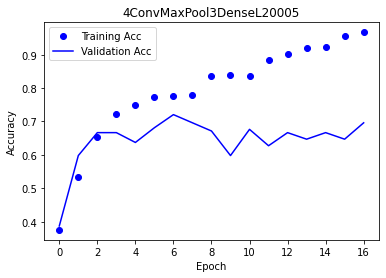

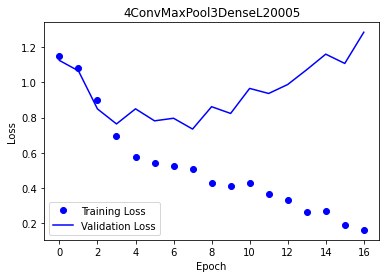

In [61]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

reg = regularizers.L1L2(l2=0.0005)

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), kernel_regularizer=reg, activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 12, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 3, kernel_regularizer=reg, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseL20005.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [62]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 1s 24ms/step - loss: 0.6761 - accuracy: 0.7435
Test: {'accuracy': 0.7434782385826111, 'loss': 0.676052987575531}
17/17 [==============================] - 1s 30ms/step - loss: 0.7625 - accuracy: 0.6912
Val: {'accuracy': 0.6911764740943909, 'loss': 0.7624698877334595}
61/61 [==============================] - 1s 25ms/step - loss: 0.3953 - accuracy: 0.8475
Train: {'accuracy': 0.8475409746170044, 'loss': 0.3952556550502777}


Observe Dropout

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 28, 28, 32)      

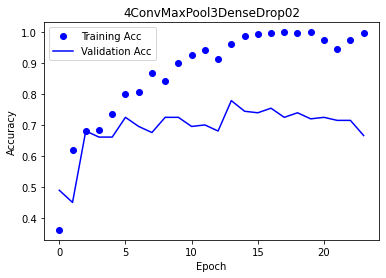

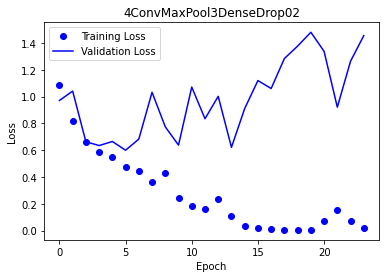

In [63]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dropout(0.2) )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseDrop02.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [64]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 1s 25ms/step - loss: 0.5647 - accuracy: 0.7522
Test: {'accuracy': 0.752173900604248, 'loss': 0.5647426843643188}
17/17 [==============================] - 0s 29ms/step - loss: 0.6153 - accuracy: 0.7157
Val: {'accuracy': 0.7156862616539001, 'loss': 0.6152581572532654}
61/61 [==============================] - 2s 26ms/step - loss: 0.4237 - accuracy: 0.8148
Train: {'accuracy': 0.814754068851471, 'loss': 0.4237176775932312}


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 28, 28, 32)      

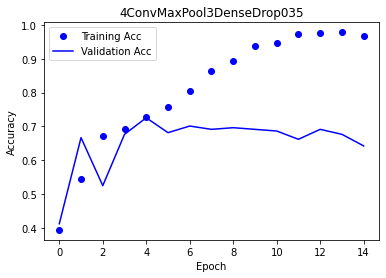

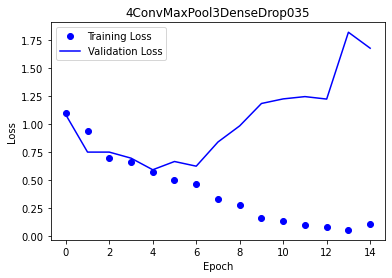

In [65]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dropout(0.35) )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseDrop035.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [66]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 1s 23ms/step - loss: 0.6680 - accuracy: 0.6652
Test: {'accuracy': 0.665217399597168, 'loss': 0.6679696440696716}
17/17 [==============================] - 0s 28ms/step - loss: 0.6474 - accuracy: 0.6814
Val: {'accuracy': 0.6813725233078003, 'loss': 0.6474318504333496}
61/61 [==============================] - 1s 24ms/step - loss: 0.4808 - accuracy: 0.8115
Train: {'accuracy': 0.811475396156311, 'loss': 0.48080623149871826}


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 28, 28, 32)      

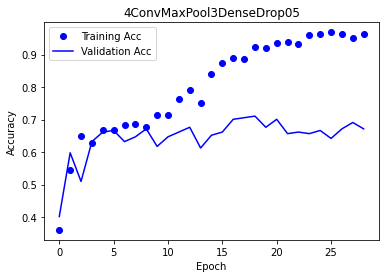

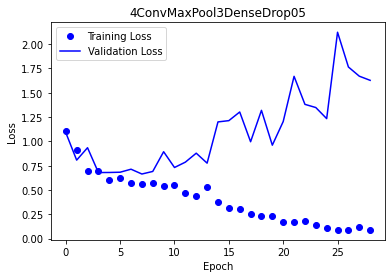

In [67]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dropout(0.5) )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseDrop05.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [68]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 1s 23ms/step - loss: 0.6900 - accuracy: 0.6957
Test: {'accuracy': 0.695652186870575, 'loss': 0.689970076084137}
17/17 [==============================] - 0s 29ms/step - loss: 0.6846 - accuracy: 0.6471
Val: {'accuracy': 0.6470588445663452, 'loss': 0.684571385383606}
61/61 [==============================] - 1s 25ms/step - loss: 0.5629 - accuracy: 0.6918
Train: {'accuracy': 0.6918032765388489, 'loss': 0.5629224181175232}


Observe Batch Normalization

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
batch_normalization_7 (Batch (None, 254, 254, 12)      48        
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
batch_normalization_8 (Batch (None, 125, 125, 12)      48        
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 60, 60, 32)      

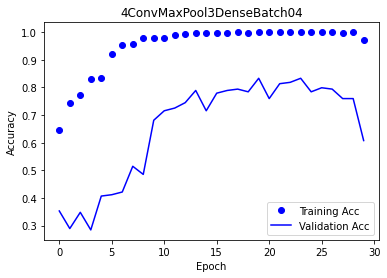

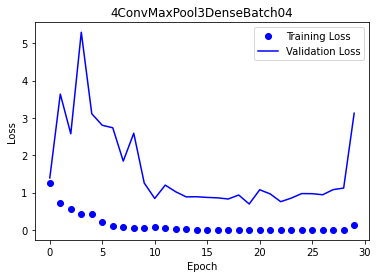

In [69]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( BatchNormalization())
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( BatchNormalization())
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( BatchNormalization())
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( BatchNormalization())
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseBatch04.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [70]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 1s 23ms/step - loss: 1.2289 - accuracy: 0.7652
Test: {'accuracy': 0.7652173638343811, 'loss': 1.2289035320281982}
17/17 [==============================] - 0s 28ms/step - loss: 0.8673 - accuracy: 0.8039
Val: {'accuracy': 0.8039215803146362, 'loss': 0.867326557636261}
61/61 [==============================] - 2s 25ms/step - loss: 7.0725e-04 - accuracy: 1.0000
Train: {'accuracy': 1.0, 'loss': 0.0007072548614814878}


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 254, 254, 12)      336       
_________________________________________________________________
batch_normalization_11 (Batc (None, 254, 254, 12)      48        
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 125, 125, 12)      1308      
_________________________________________________________________
batch_normalization_12 (Batc (None, 125, 125, 12)      48        
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 60, 60, 32)      

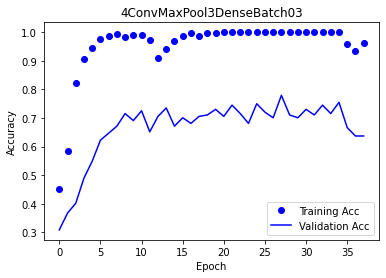

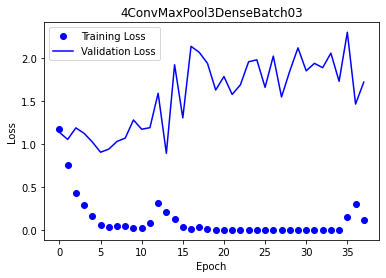

In [71]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( BatchNormalization())
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( BatchNormalization())
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( BatchNormalization())
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseBatch03.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [72]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 1s 24ms/step - loss: 1.2912 - accuracy: 0.6913
Test: {'accuracy': 0.6913043260574341, 'loss': 1.291172742843628}
17/17 [==============================] - 1s 30ms/step - loss: 0.9632 - accuracy: 0.7304
Val: {'accuracy': 0.7303921580314636, 'loss': 0.9631621241569519}
61/61 [==============================] - 2s 25ms/step - loss: 0.0795 - accuracy: 0.9754
Train: {'accuracy': 0.9754098653793335, 'loss': 0.07948492467403412}
